## 1. Import data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/supplement.csv")
data.columns = data.columns.str.lower()
data = data.sample(frac=1)
data.drop_duplicates(keep="first", inplace=True)
data.head()

id  store_id store_type location_type region_code        date  \
57294   T1057295        18         S4            L1          R1  2018-06-06   
54658   T1054659       200         S2            L1          R2  2018-05-30   
121112  T1121113       129         S3            L1          R1  2018-11-28   
64613   T1064614       279         S2            L3          R2  2018-06-27   
99943   T1099944       274         S4            L2          R4  2018-10-01   

        holiday discount  #order    sales  
57294         0       No      69  40251.0  
54658         0       No      43  37998.0  
121112        0       No      74  39543.0  
64613         0       No      40  28086.0  
99943         0      Yes      98  62745.0

In [2]:
data.shape

(188340, 10)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188340 entries, 57294 to 160635
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             188340 non-null  object 
 1   store_id       188340 non-null  int64  
 2   store_type     188340 non-null  object 
 3   location_type  188340 non-null  object 
 4   region_code    188340 non-null  object 
 5   date           188340 non-null  object 
 6   holiday        188340 non-null  int64  
 7   discount       188340 non-null  object 
 8   #order         188340 non-null  int64  
 9   sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 15.8+ MB


In [4]:
data.describe()

store_id        holiday         #order          sales
count  188340.000000  188340.000000  188340.000000  188340.000000
mean      183.000000       0.131783      68.205692   42784.327982
std       105.366308       0.338256      30.467415   18456.708302
min         1.000000       0.000000       0.000000       0.000000
25%        92.000000       0.000000      48.000000   30426.000000
50%       183.000000       0.000000      63.000000   39678.000000
75%       274.000000       0.000000      82.000000   51909.000000
max       365.000000       1.000000     371.000000  247215.000000

## 2. Feature Eng

### 2.1. Explode date for new feature generation

In [5]:
import datetime as dt

def get_datetimes(df):

  df['date'] = pd.to_datetime(df['date'])
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['week'] = df['date'].dt.isocalendar().week
  df['weekend'] = df['week'].apply(lambda x: 1 if x in [6,7] else 0)
  df['day_of_week'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter   
  return df

df_dt = get_datetimes(data)
df_dt.head(3)


id  store_id store_type location_type region_code       date  \
57294   T1057295        18         S4            L1          R1 2018-06-06   
54658   T1054659       200         S2            L1          R2 2018-05-30   
121112  T1121113       129         S3            L1          R1 2018-11-28   

        holiday discount  #order    sales  year  month  day  week  weekend  \
57294         0       No      69  40251.0  2018      6    6    23        0   
54658         0       No      43  37998.0  2018      5   30    22        0   
121112        0       No      74  39543.0  2018     11   28    48        0   

        day_of_week  quarter  
57294             2        2  
54658             2        2  
121112            2        4

In [ ]:
# #predict sales
# ## drop some unnecessary columns
# df_dt = df_dt.drop(["id","date",'#order'], axis=1)
# ##change sales column index
# df_dt.insert(0, 'sales', df_dt.pop("sales"))
# ##rename sales as target_variable
# df_dt.columns = df_dt.columns.str.replace('sales', 'target_variable')
# df_dt.head(3)

### adjust columns

In [6]:
#predict order
## drop some unnecessary columns
df_dt = df_dt.drop(["id","date"], axis=1)
##change sales column index
df_dt.insert(0, '#order', df_dt.pop("#order"))
##rename sales as target_variable
df_dt.columns = df_dt.columns.str.replace('#order', 'target_variable')
df_dt.head(3)

target_variable  store_id store_type location_type region_code  \
57294                69        18         S4            L1          R1   
54658                43       200         S2            L1          R2   
121112               74       129         S3            L1          R1   

        holiday discount    sales  year  month  day  week  weekend  \
57294         0       No  40251.0  2018      6    6    23        0   
54658         0       No  37998.0  2018      5   30    22        0   
121112        0       No  39543.0  2018     11   28    48        0   

        day_of_week  quarter  
57294             2        2  
54658             2        2  
121112            2        4

## 2.2 Check target_variable distribution

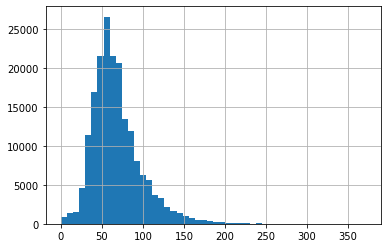

In [ ]:
hist = df_dt.target_variable.hist(bins=50)

target_variable is not Normaly distributed , it is Skewed and to solve this apply log transformation on target variable when it has skewed distribution.

In [7]:
df_dt['lognorm_target_var'] = np.log(df_dt['target_variable'])

/Users/aydin/Documents/JSL/mlops-gitlab/mlops-prj/EnvMLOPS/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
df_dt = df_dt[df_dt.lognorm_target_var>2]
df_dt[['target_variable', 'lognorm_target_var']].describe()

target_variable  lognorm_target_var
count    187437.000000       187437.000000
mean         68.506944            4.135212
std          30.229080            0.437415
min           8.000000            2.079442
25%          48.000000            3.871201
50%          63.000000            4.143135
75%          82.000000            4.406719
max         371.000000            5.916202

In [ ]:
df_dt.shape

(187437, 16)

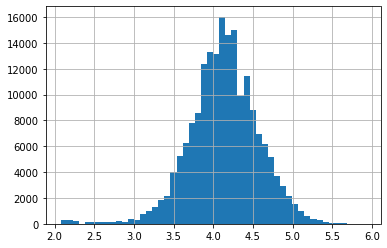

In [ ]:
hist2 = df_dt.lognorm_target_var.hist(bins=50)

## 2.2. Encoding Categorical Features

In [9]:
# columns to keep as categorical
categorical_columns = ['store_type', 'store_id',
                      'location_type', 'region_code',
                      'holiday', 'discount', 
                      'year', 'month',
                      'day', 'week', 'weekend', 
                      'day_of_week', 'quarter']

### 2.2.1. Encode categorical features using map dict

In [10]:
df_mapped = df_dt.copy()

In [11]:
df_mapped["discount"] = df_mapped["discount"].map({"No": 0, "Yes": 1})
df_mapped["store_type"] = df_mapped["store_type"].map({"S1": 1, "S2": 2, "S3": 3, "S4": 4})
df_mapped["location_type"] = df_mapped["location_type"].map({"L1": 1, "L2": 2, "L3": 3, "L4": 4, "L5": 5})
df_mapped["region_code"] = df_mapped["region_code"].map({"R1": 1, "R2": 2, "R3": 3, "R4": 4})
df_mapped["year"] = df_mapped["year"].map({2018: 1, 2019: 2})

In [12]:
df_mapped.head()

target_variable  store_id  store_type  location_type  region_code  \
57294                69        18           4              1            1   
54658                43       200           2              1            2   
121112               74       129           3              1            1   
64613                40       279           2              3            2   
99943                98       274           4              2            4   

        holiday  discount    sales  year  month  day  week  weekend  \
57294         0         0  40251.0     1      6    6    23        0   
54658         0         0  37998.0     1      5   30    22        0   
121112        0         0  39543.0     1     11   28    48        0   
64613         0         0  28086.0     1      6   27    26        0   
99943         0         1  62745.0     1     10    1    40        0   

        day_of_week  quarter  lognorm_target_var  
57294             2        2            4.234107  
54658             2        2            3.761200  
121112            2        4            4.304065  
64613             2        2            3.688879  
99943             0        4            4.584967

### 2.2.2 Encode categorical features using get_dummies

In [13]:
df_dummies = pd.get_dummies(data=df_dt, columns=categorical_columns)
df_dummies.head(2)

target_variable    sales  lognorm_target_var  store_type_S1  \
57294               69  40251.0            4.234107              0   
54658               43  37998.0            3.761200              0   

       store_type_S2  store_type_S3  store_type_S4  store_id_1  store_id_2  \
57294              0              0              1           0           0   
54658              1              0              0           0           0   

       store_id_3  ...  day_of_week_1  day_of_week_2  day_of_week_3  \
57294           0  ...              0              1              0   
54658           0  ...              0              1              0   

       day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  quarter_2  \
57294              0              0              0          0          1   
54658              0              0              0          0          1   

       quarter_3  quarter_4  
57294          0          0  
54658          0          0  

[2 rows x 495 columns]

In [14]:
# add numerical value to dataset
df_dummies['sales'] = df_dt["sales"].values

df_dummies.head(2)

target_variable    sales  lognorm_target_var  store_type_S1  \
57294               69  40251.0            4.234107              0   
54658               43  37998.0            3.761200              0   

       store_type_S2  store_type_S3  store_type_S4  store_id_1  store_id_2  \
57294              0              0              1           0           0   
54658              1              0              0           0           0   

       store_id_3  ...  day_of_week_1  day_of_week_2  day_of_week_3  \
57294           0  ...              0              1              0   
54658           0  ...              0              1              0   

       day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  quarter_2  \
57294              0              0              0          0          1   
54658              0              0              0          0          1   

       quarter_3  quarter_4  
57294          0          0  
54658          0          0  

[2 rows x 495 columns]

In [15]:
df_dummies.shape

(187437, 495)

### 2.2.3. Encode categoricals using sklearn - label encoder 

In [ ]:
# Assignment for all and Ahmet for prasentation

## 2.3 Scale numerical feature

In [22]:
#!pip install scikit-learn

In [23]:
# scale numerical feature "sales"
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_dummies[['sales']] = scaler.fit_transform(df_dummies[["sales"]])


In [24]:
df_dummies[['sales']].head()

sales
57294   0.150026
54658   0.140773
121112  0.147118
64613   0.100066
99943   0.242406

In [25]:
df_dummies.head(3)

target_variable     sales  lognorm_target_var  store_type_S1  \
57294                69  0.150026            4.234107              0   
54658                43  0.140773            3.761200              0   
121112               74  0.147118            4.304065              0   

        store_type_S2  store_type_S3  store_type_S4  store_id_1  store_id_2  \
57294               0              0              1           0           0   
54658               1              0              0           0           0   
121112              0              1              0           0           0   

        store_id_3  ...  day_of_week_1  day_of_week_2  day_of_week_3  \
57294            0  ...              0              1              0   
54658            0  ...              0              1              0   
121112           0  ...              0              1              0   

        day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  quarter_2  \
57294               0              0              0          0          1   
54658               0              0              0          0          1   
121112              0              0              0          0          0   

        quarter_3  quarter_4  
57294           0          0  
54658           0          0  
121112          0          1  

[3 rows x 495 columns]

In [27]:
df_dummies_2 = pd.concat([pd.DataFrame(df_dummies.iloc[:,0]), pd.DataFrame(df_dummies.iloc[:,2]), pd.DataFrame(df_dummies.iloc[:,1]), df_dummies.iloc[:,3:]], axis=1)
df_dummies_2.head(3)

target_variable  lognorm_target_var     sales  store_type_S1  \
57294                69            4.234107  0.150026              0   
54658                43            3.761200  0.140773              0   
121112               74            4.304065  0.147118              0   

        store_type_S2  store_type_S3  store_type_S4  store_id_1  store_id_2  \
57294               0              0              1           0           0   
54658               1              0              0           0           0   
121112              0              1              0           0           0   

        store_id_3  ...  day_of_week_1  day_of_week_2  day_of_week_3  \
57294            0  ...              0              1              0   
54658            0  ...              0              1              0   
121112           0  ...              0              1              0   

        day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  quarter_2  \
57294               0              0              0          0          1   
54658               0              0              0          0          1   
121112              0              0              0          0          0   

        quarter_3  quarter_4  
57294           0          0  
54658           0          0  
121112          0          1  

[3 rows x 495 columns]

In [28]:
df_dummies_2.to_csv("preprocessed_data.csv")

In [ ]:
# How and why to use scaler? >> Halil

## 3. Model Development

### 3.1. Data Set Test Train Split 

In [29]:
# df_shuffled = df_mapped.sample(frac=1)
df_shuffled = df_dummies_2.sample(frac=1)
print(df_shuffled.shape)
validation_set = df_shuffled.iloc[0:100]
df_shuffled = df_shuffled.iloc[100::]
print(df_shuffled.shape)

(187437, 495)
(187337, 495)


In [ ]:
use_sales = False
if use_sales: 
  X = df_shuffled.iloc[:, 2:]
  i=2
else:
  X = df_shuffled.iloc[:, 3:]
  i=3

print(X.shape)
print(X.columns[0:i], X.columns[-1])

use_log_normalized = False
if use_log_normalized:
  y = df_shuffled.iloc[:,1]
else:
  y = df_shuffled.iloc[:,0]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

(187337, 492)
Index(['store_type_S1', 'store_type_S2', 'store_type_S3'], dtype='object') quarter_4


### 3.2. Linear Regression

In [1]:
from sklearn.linear_model import LinearRegression

In [2]:
reg_log_normalized = LinearRegression().fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
reg_non_normalized = LinearRegression().fit(X_train, y_train)


# Model Performances

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def metrics(reg):
    # Make predictions using the test set
    y_pred = reg.predict(X_test)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print the results
    print("Mean Squared Error: ", mse)
    print("Root Mean Squared Error: ", rmse)

def r_squared(reg):
    y_pred = reg.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    r2_score = reg.score(X_test, y_test)
    print("R-squared: ", r2_score)

In [ ]:
# target variable log normalized with sales
metrics(reg_log_normalized)
r_squared(reg_log_normalized)

Mean Squared Error:  0.05576154460787766
Root Mean Squared Error:  0.23613882486342153
R-squared:  0.709611612225711


In [ ]:
# target variable not normalized with sales
metrics(reg_non_normalized)
r_squared(reg_non_normalized)

## Predictions on validation data

In [ ]:
#pd.DataFrame(validation_set.iloc[1, 3:]).T

In [ ]:
import math

def prediction(index):
    normalized = reg_log_normalized.predict(pd.DataFrame(validation_set.iloc[index, 3:]).T)
    non_normalized = reg_non_normalized.predict(pd.DataFrame(validation_set.iloc[index, 3:]).T)

    print("normalized:", math.exp(normalized[0]))
    print("not normalized:", non_normalized[0])
    print("ground truth:", validation_set.iloc[index,0])


In [ ]:
prediction(7)

normalized: 40.57389988868238
not normalized: 39.1015625
ground truth: 58


### 3.3. LightGBM

In [ ]:
# Use pip install lightgbm to install it on your system
#!pip install -q lightgbm

In [ ]:

import lightgbm as ltb
model = ltb.LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
ypred = model.predict(X_test)

In [ ]:
y_test = list(y_test.values)
y_pred = [int(x.round()) for x in list(ypred)]

In [ ]:
from sklearn.metrics import r2_score

accuracy = r2_score(y_test, y_pred)
accuracy

0.42917030963135017

In [ ]:
accuracy = r2_score(y_test, y_pred)
accuracy

0.5895665431454191

In [ ]:
accuracy = r2_score(y_test, y_pred)
accuracy

0.984714547459133

In [ ]:
accuracy = r2_score(y_test, y_pred)
accuracy

0.8194877101881743

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.331078555580971

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.28073667546521996

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

3.7325051856673173

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

12.82669172068508

### 3.3. train, save and load model using pipeline and pkl


In [ ]:
df_dt.head(1)

target_variable  store_id store_type location_type region_code  \
43745               63        35         S1            L1          R2   

       holiday discount  year  month  day  week  day_of_week  quarter  
43745        1       No  2018      4   30    18            0        2

https://towardsdatascience.com/using-pipelines-in-sci-kit-learn-516aa431dcc5

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
import lightgbm as ltb

df =  df_dt.sample(frac=1)

categorical_columns = ['store_id', 'store_type',
                      'location_type', 'region_code',
                      'holiday', 'discount', 
                      'year', 'month',
                      'day', 'week', 'day_of_week', 'quarter']

numerical_columns = ['sales']

# Create a ColumnTransformer with a OneHotEncoder for categorical columns, and a MinMaxScaler for numerical columns
ct = ColumnTransformer([
    ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_columns),
    ('scaler', MinMaxScaler(), numerical_columns)
])

# Use the ColumnTransformer to transform the data
# ct.fit_transform(df)

# Create a Pipeline with a ColumnTransformer and a Regression Model
pipeline = Pipeline([
    ('transformer', ct),
    ('regressor', ltb.LGBMRegressor())
])

# Fit the model to the data
pipeline.fit(df, df['target_variable'])

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_id', 'store_type',
                                                   'location_type',
                                                   'region_code', 'holiday',
                                                   'discount', 'year', 'month',
                                                   'day', 'week', 'day_of_week',
                                                   'quarter']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['sales'])])),
                ('regressor', LGBMRegressor())])

### 3.4. Prediction

In [ ]:
def do_inference(index):
  data_point = pd.DataFrame(df.iloc[index,:]).T
  true_value = df.loc[index,'target_variable']
  predicted_value = pipeline.predict(data_point)

  return {"true_value": true_value,
          "predicted_value": predicted_value}

In [ ]:
index = 267
do_inference(index)

{'true_value': 24, 'predicted_value': array([28.59581015])}

In [ ]:
import pickle
# Use pickle to save model for next usage.
filename = 'model_v1.pk'
with open('./'+filename, 'wb') as file:
    pickle.dump(pipeline, file) 

In [ ]:
with open('./'+filename ,'rb') as f:
    loaded_model = pickle.load(f)

## 4. Pycaret

In [ ]:
!pip install -q pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (s

In [ ]:
from pycaret.regression import *

ImportError: ignored

In [ ]:
df_shuffled.head(2)

In [ ]:
df_shuffled.shape

In [ ]:
from sklearn.model_selection import train_test_split
data = df_shuffled
train, test = train_test_split(data, test_size=0.2)


In [ ]:
reg = setup(data = train, target = 'target_variable', session_id=123)

In [ ]:
compare_models()


# 3. AutoML- H2O

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628739 sha256=471aa3e186dc24418cfe69876a2584aa73fc1e41da182f45bf651eb454b23f57
  Stored in directory: /root/.cache/pip/wheels/6b/1d/65/39927b5984bde22f615b4c6e9a8ee98ea4abf1acb5926623ff
Successfully built h2o


In [ ]:
import h2o 
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppprbcfjz
  JVM stdout: /tmp/tmppprbcfjz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppprbcfjz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.4
H2O_cluster_version_age:    9 days
H2O_cluster_name:           H2O_from_python_unknownUser_3ssjav
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.16 final
--------------------------  ----------------------------------

In [ ]:
import pandas as pd
import numpy as np

# data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/supplement.csv")
# data.columns = data.columns.str.lower()
# data = data.sample(frac=1)
# data.drop_duplicates(keep="first", inplace=True)
# data.head()

data = h2o.import_file("/content/preprocessed_data.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
data.describe()

Rows:187437
Cols:496

C1                  target_variable     lognorm_target_var    sales                store_type_S1        store_type_S2        store_type_S3        store_type_S4        store_id_1             store_id_2            store_id_3             store_id_4             store_id_5             store_id_6             store_id_7            store_id_8             store_id_9             store_id_10            store_id_11            store_id_12            store_id_13            store_id_14            store_id_15            store_id_16            store_id_17            store_id_18            store_id_19           store_id_20            store_id_21            store_id_22            store_id_23            store_id_24           store_id_25            store_id_26           store_id_27            store_id_28            store_id_29            store_id_30            store_id_31            store_id_32           store_id_33           store_id_34           store_id_35           store_id_36            store_id_37            store_id_38            store_id_39            store_id_40            store_id_41            store_id_42            store_id_43            store_id_44            store_id_45            store_id_46            store_id_47            store_id_48           store_id_49            store_id_50            store_id_51            store_id_52            store_id_53            store_id_54            store_id_55            store_id_56            store_id_57            store_id_58            store_id_59            store_id_60            store_id_61            store_id_62            store_id_63           store_id_64            store_id_65            store_id_66            store_id_67            store_id_68            store_id_69            store_id_70            store_id_71            store_id_72            store_id_73            store_id_74            store_id_75            store_id_76            store_id_77            store_id_78           store_id_79            store_id_80            store_id_81           store_id_82            store_id_83            store_id_84           store_id_85            store_id_86            store_id_87           store_id_88            store_id_89            store_id_90            store_id_91           store_id_92            store_id_93            store_id_94            store_id_95           store_id_96            store_id_97            store_id_98            store_id_99           store_id_100           store_id_101          store_id_102           store_id_103           store_id_104           store_id_105           store_id_106           store_id_107           store_id_108           store_id_109           store_id_110           store_id_111           store_id_112           store_id_113           store_id_114          store_id_115           store_id_116           store_id_117          store_id_118          store_id_119           store_id_120           store_id_121          store_id_122           store_id_123           store_id_124           store_id_125           store_id_126           store_id_127           store_id_128           store_id_129          store_id_130          store_id_131           store_id_132           store_id_133          store_id_134           store_id_135          store_id_136           store_id_137           store_id_138          store_id_139           store_id_140           store_id_141           store_id_142           store_id_143           store_id_144           store_id_145           store_id_146           store_id_147           store_id_148           store_id_149           store_id_150           store_id_151           store_id_152           store_id_153           store_id_154           store_id_155           store_id_156           store_id_157           store_id_158           store_id_159           store_id_160           store_id_161           store_id_162           store_id_163          store_id_164          store_id_165           store_id_166           store_id_167           store_id_168          

In [ ]:
train, valid, test = data.split_frame(ratios=[0.7,0.2], seed=1234)
print("Number of rows in train : ", train.shape[0])
print("Number of rows in test : ", test.shape[0])
print("Number of rows in Validation : ", valid.shape[0])

Number of rows in train :  131286
Number of rows in test :  18937
Number of rows in Validation :  37214


In [ ]:
aml = H2OAutoML(max_models = 10, max_runtime_secs=300,exclude_algos=
               [], seed = 1)

In [ ]:
data.columns


['C1',
 'target_variable',
 'lognorm_target_var',
 'sales',
 'store_type_S1',
 'store_type_S2',
 'store_type_S3',
 'store_type_S4',
 'store_id_1',
 'store_id_2',
 'store_id_3',
 'store_id_4',
 'store_id_5',
 'store_id_6',
 'store_id_7',
 'store_id_8',
 'store_id_9',
 'store_id_10',
 'store_id_11',
 'store_id_12',
 'store_id_13',
 'store_id_14',
 'store_id_15',
 'store_id_16',
 'store_id_17',
 'store_id_18',
 'store_id_19',
 'store_id_20',
 'store_id_21',
 'store_id_22',
 'store_id_23',
 'store_id_24',
 'store_id_25',
 'store_id_26',
 'store_id_27',
 'store_id_28',
 'store_id_29',
 'store_id_30',
 'store_id_31',
 'store_id_32',
 'store_id_33',
 'store_id_34',
 'store_id_35',
 'store_id_36',
 'store_id_37',
 'store_id_38',
 'store_id_39',
 'store_id_40',
 'store_id_41',
 'store_id_42',
 'store_id_43',
 'store_id_44',
 'store_id_45',
 'store_id_46',
 'store_id_47',
 'store_id_48',
 'store_id_49',
 'store_id_50',
 'store_id_51',
 'store_id_52',
 'store_id_53',
 'store_id_54',
 'store_id_55

In [ ]:
features_to_remove = ['target_variable',
 'lognorm_target_var',]

In [ ]:
independent_features = [x for x in data.columns if x not in features_to_remove]


In [ ]:
aml.train(x = independent_features, y = 'lognorm_target_var',
          training_frame = train, validation_frame=valid)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_5_20230115_181050


Model Summary: 
    number_of_trees
--  -----------------
    270

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.000587664221523068
RMSE: 0.024241786681741675
MAE: 0.018701886012724142
RMSLE: 0.004838368638011612
Mean Residual Deviance: 0.000587664221523068

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.0015017077926196072
RMSE: 0.0387518746981305
MAE: 0.028707025084047332
RMSLE: 0.00799756150036968
Mean Residual Deviance: 0.0015017077926196072

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse         training_mae          training_deviance      validation_rmse       validation_mae        validation_deviance
---  -------------------  ----------------  -----------------  --------------------  --------------------  ---------------------  --------------------  --------------------  ---------------------
     2023-01-15 18:10:53  0.031 sec         0.0                3.659717148260864     3.6335242140943023    13.393529605274631     3.6633159825547117    3.636898314452488     13.419883988040793
     2023-01-15 18:10:59  5.522 sec         5.0                0.6279030431456886    0.6126809297140163    0.39426223159161644    0.6280018850127922    0.6126226465251154    0.3943863675796202
     2023-01-15 18:11:01  8.363 sec         10.0               0.12542382917830366   0.10845256222712371   0.0157311369257483     0.1264775382790722    0.10879019088412482   0.015996567689134173
     2023-01-15 18:11:04  11.319 sec        15.0               0.05828107574882699   0.04625128598395895   0.0033966837904405097  0.062456327174386914  0.04888264923533408   0.003900792804114061
     2023-01-15 18:11:07  14.379 sec        20.0               0.0504980069287736    0.03981009542919323   0.0025500487037784666  0.05562151663422453   0.04292222631799609   0.003093753112691316
     2023-01-15 18:11:11  17.474 sec        25.0               0.047855501982287475  0.03756068617366808   0.0022901490699767206  0.05320603978162935   0.040785771762433566  0.0028308826692443247
     2023-01-15 18:11:14  20.618 sec        30.0               0.04557789609775986   0.03569861689324694   0.0020773446126981935  0.051121333721276696  0.03904781072728002   0.002613390761442142
     2023-01-15 18:11:17  23.851 sec        35.0               0.04391414658426119   0.03425721321631332   0.0019284522702239784  0.04971057622647531   0.037758419007189445  0.002471141388768212
     2023-01-15 18:11:20  27.104 sec        40.0               0.042276476368331685  0.032851659371068445  0.0017873004541221072  0.048291485210474584  0.036500016711570195  0.0023320675438334854
     2023-01-15 18:11:24  30.435 sec        45.0               0.04070645175075505   0.03159610926309615   0.001657015214136549   0.04692303368805527   0.035382025923651805  0.00220177109049037
---  ---                  ---               ---                ---                   ---                   ---                    ---                   ---                   ---
     2023-01-15 18:14:32  3 min 39.149 sec  225.0              0.025991743722969696  0.020017284011731747  0.0006755707417605345  0.03899355358791612   0.028871863944286903  0.0015204972214136862
     2023-01-15 18:14:40  3 min 46.805 sec  230.0              0.02577705731053333   0.01985704763400114   0.0006644566835905198  0.03895013324360492   0.028846446597903523  0.0015171128796945769
     2023-01-15 18:14:48  3 min 54.713 sec  235.0              0.02551971112848756   0.01966868175653115   0.000651255656081452   0.038933225351104835  0.028838323282773935  0.0015157960362399121
     2023-01-15 18:14:56  4 min  2.866 sec  240.0              0.02535934857810305   0.01954478379246664   0.0006430965603057371  0.0388952657773849    0.028817366104517555  0.0015128416998934089
     2023-01-15 18:15:04  4 min 10.995 sec  245.0              0.025234185

In [ ]:
lb = aml.leaderboard
lb.head(10)

model_id                                 rmse         mse       mae       rmsle    mean_residual_deviance
----------------------------------  ---------  ----------  --------  ----------  ------------------------
XGBoost_1_AutoML_5_20230115_181050  0.0387519  0.00150171  0.028707  0.00799756                0.00150171
[1 row x 6 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

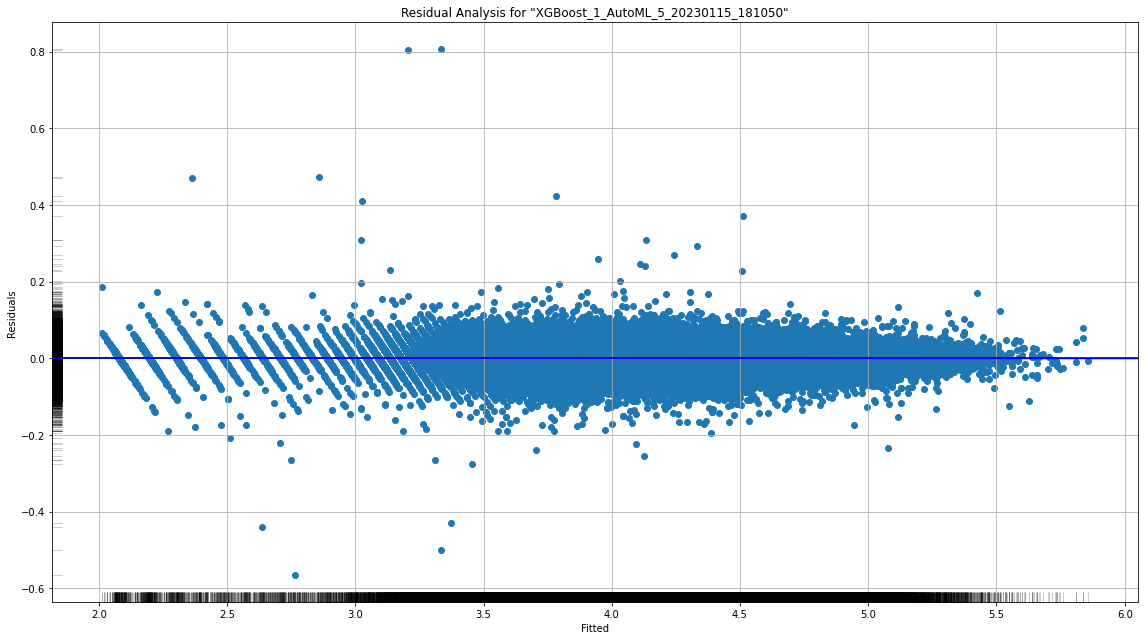

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

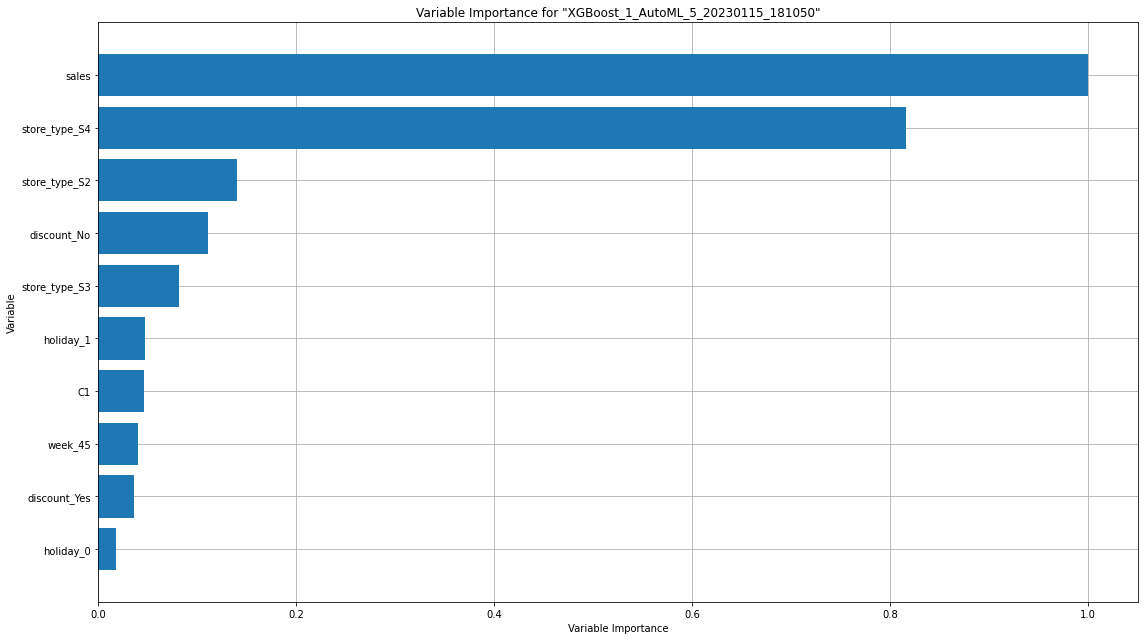

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

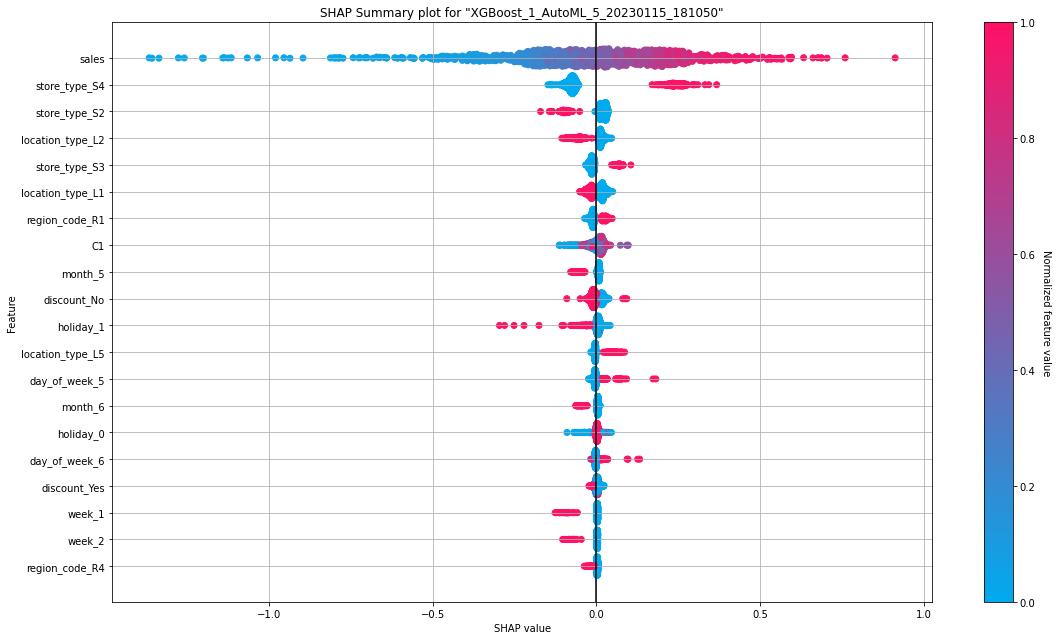

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

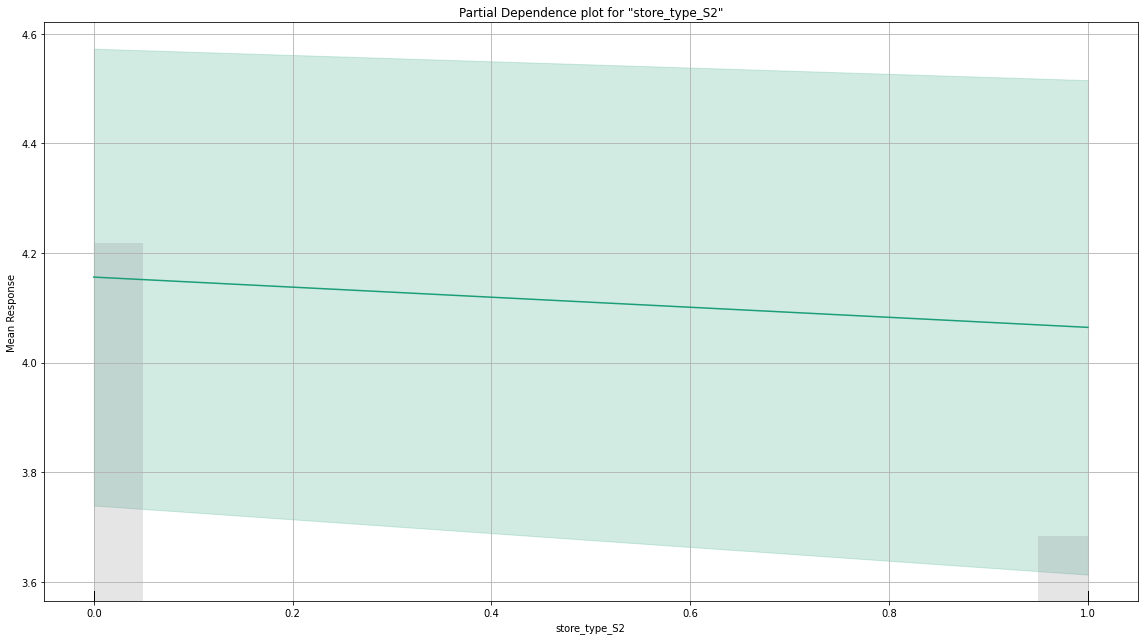

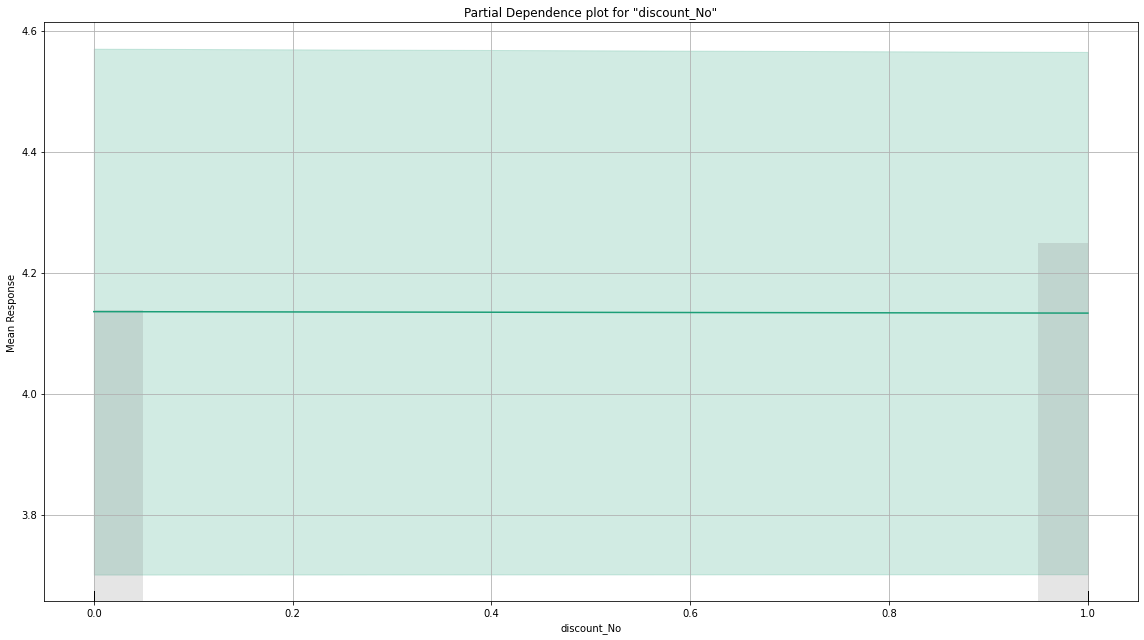

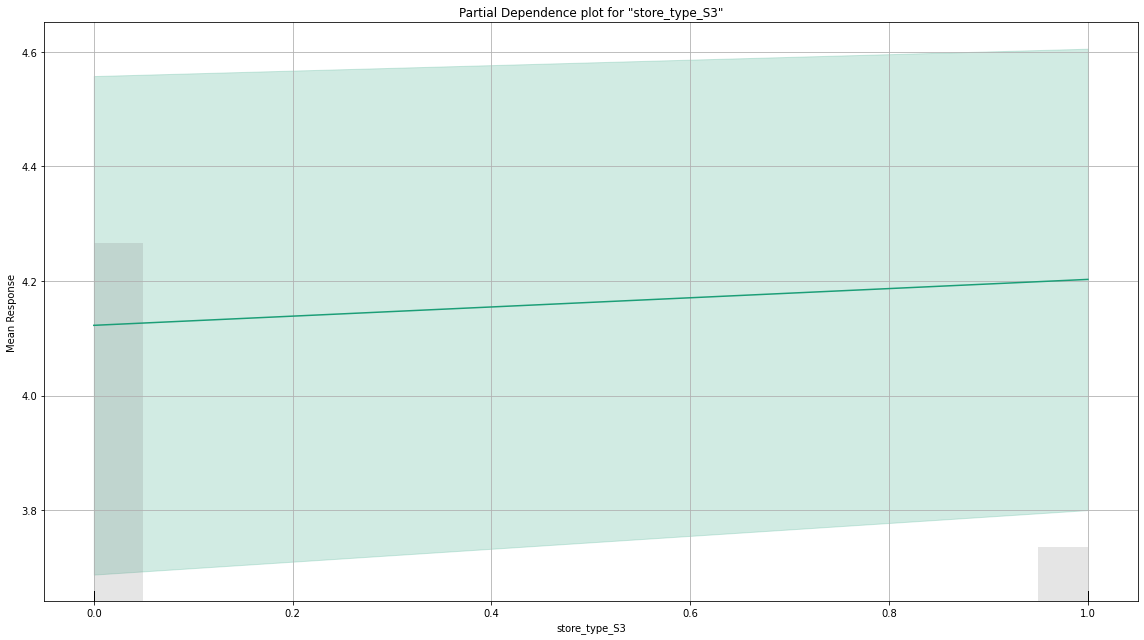

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

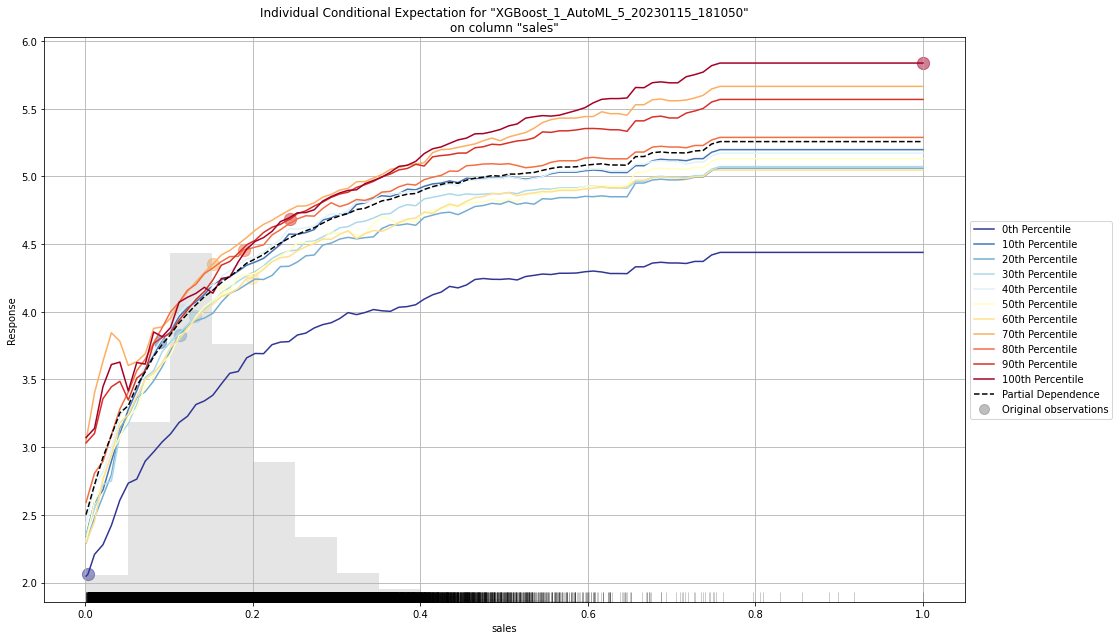

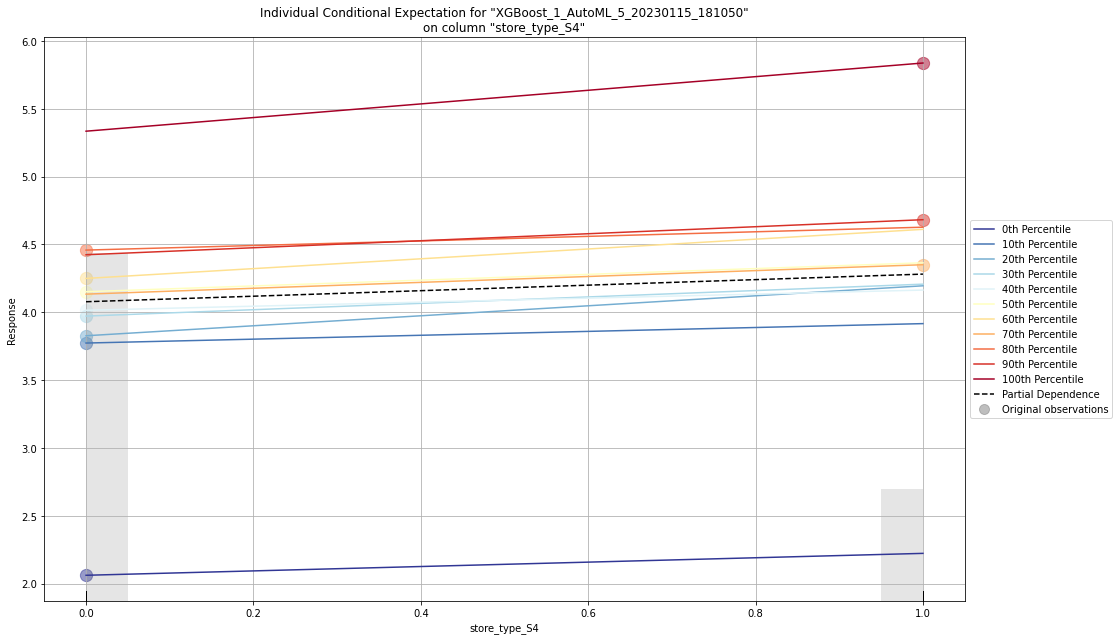

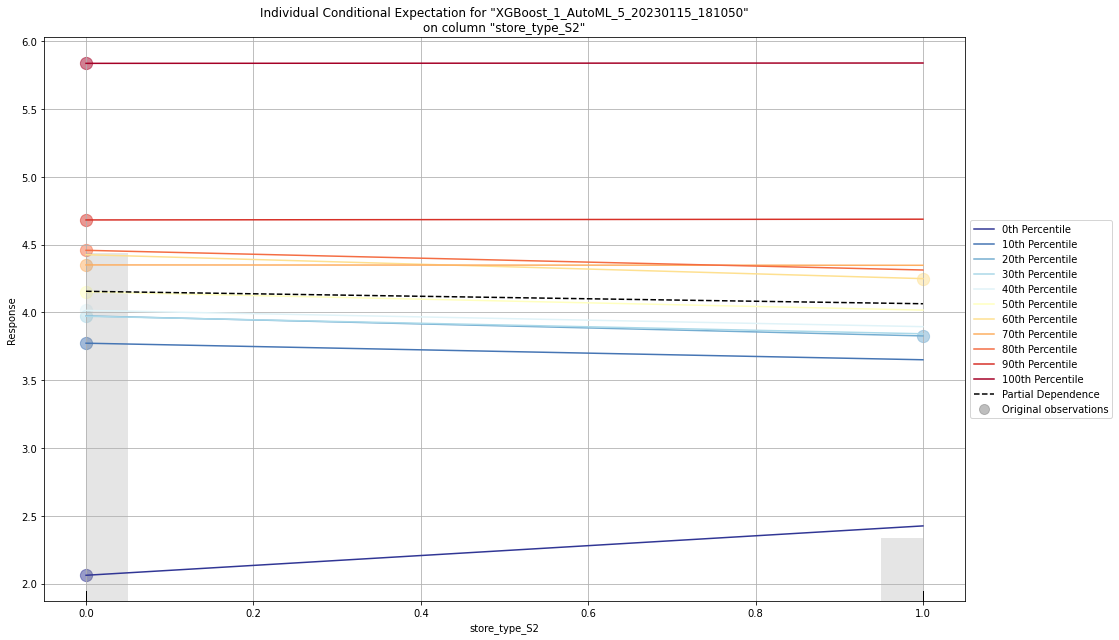

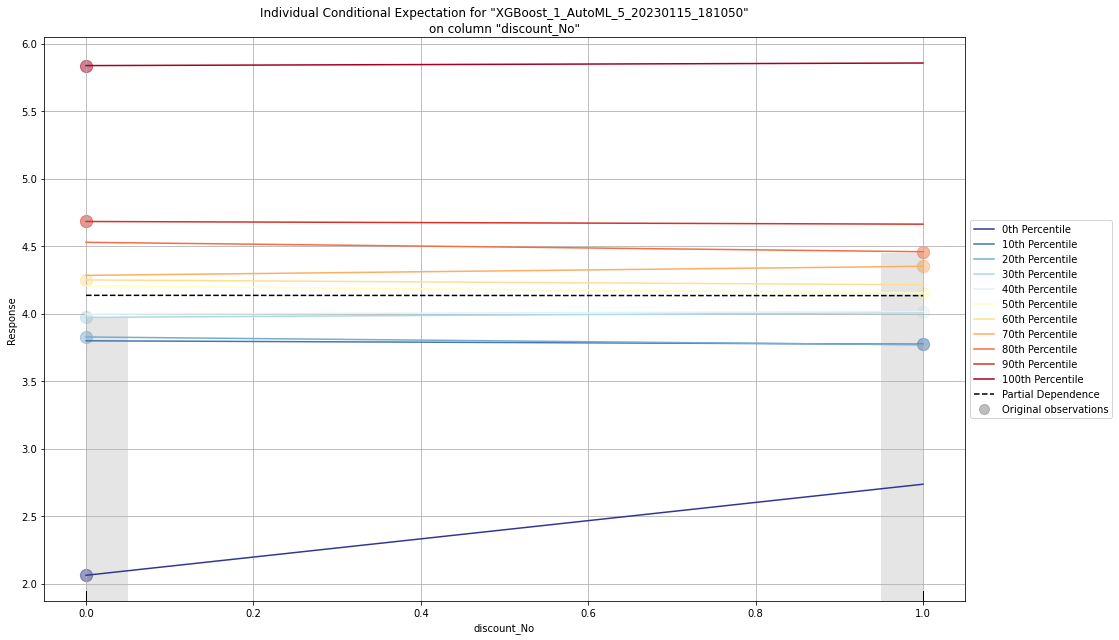

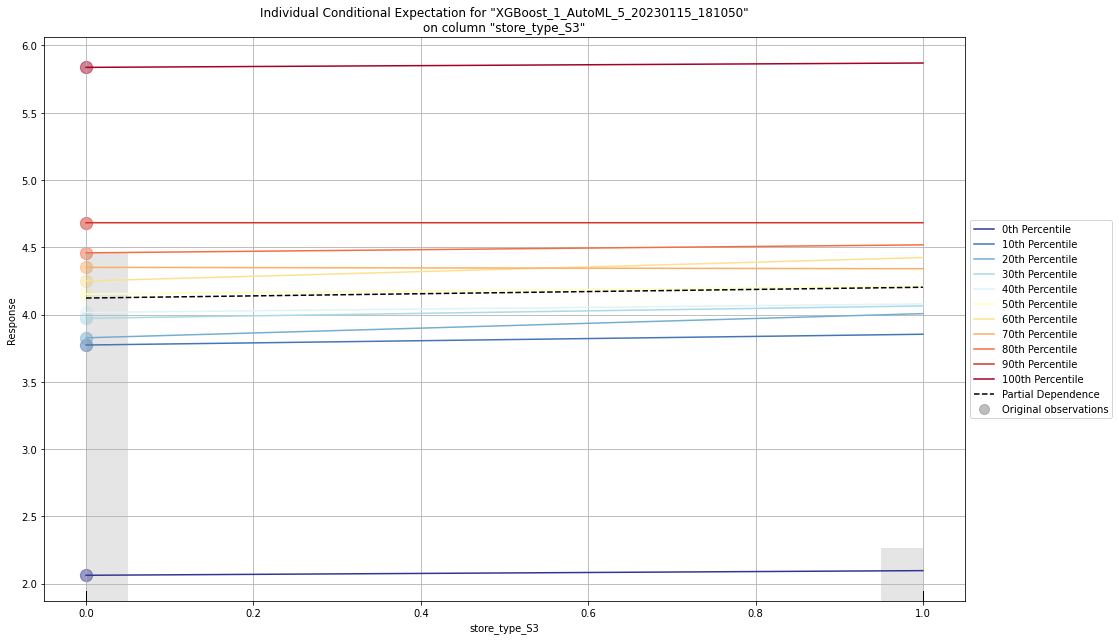

In [ ]:
explain_model = aml.leader.explain(train)

In [ ]:
preds = aml.predict(test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
preds

predict
---------
  42.9197
 132.607
 113.664
  62.6212
  41.2311
  71.6483
  66.7079
  48.7432
  75.7206
  59.1502
[18937 rows x 1 column]

In [ ]:
aml.leader.model_performance(test)

ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.001527692906007291
RMSE: 0.03908571230011411
MAE: 0.0285829245027509
RMSLE: 0.0080247687911521
Mean Residual Deviance: 0.001527692906007291

## Import Generic Manager Modules